In [1]:
from big_helper import *
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

name = 'baby'
num = 36
size = (28,28)
make_bw = True

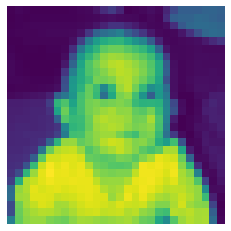

In [2]:
imgs = get_images(name, num, size) 
if name == 'TEXCOL':
    imgs = [img[0] for img in imgs] # 0 img, 1 colour mask, 2 texture mask


if make_bw == True:
    imgs = [rgb2gray(img) for img in imgs]

plot_images(imgs)

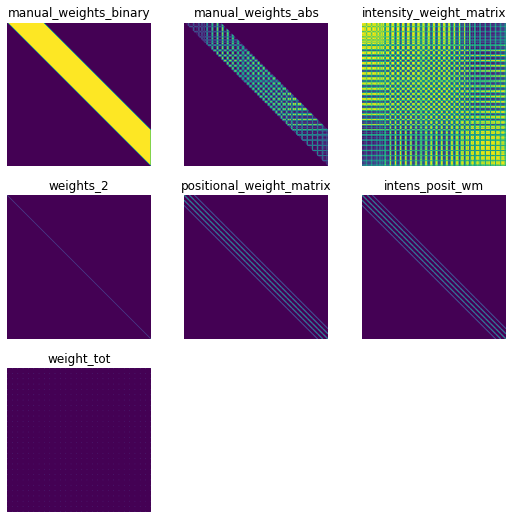

In [23]:
plt.rcParams["figure.figsize"] = (9,9) # specify the size for this cell

radius = 28*28 // 4
sigmaI = 0.1
sigmaX = 0.5

choice = 1
choices = ["manual_weights_binary", "manual_weights_abs", "intensity_weight_matrix", "weights_2", 
           "positional_weight_matrix", "intens_posit_wm", "weight_tot", "weight_int", "weight_dist"]

labels = []
normed_aswell = False

if len(imgs) == 1:
    weights = []
    for i in range(7):
        labels.append(choices[i])
        weights.append(get_weights(imgs[0], i, radius, sigmaI, sigmaX))
        if normed_aswell: # normed version too
            labels.append(choices[i] + ' norm')
            weights.append(weights[-1]/np.max(weights[-1]))
else:
    weights = [get_weights(img, choice, radius, sigmaI, sigmaX) for img in imgs]
plot_images(weights, labels)

# TODO: plot single rows to see the outputs of that (reshaped to 28x28 image)

(784, 784)


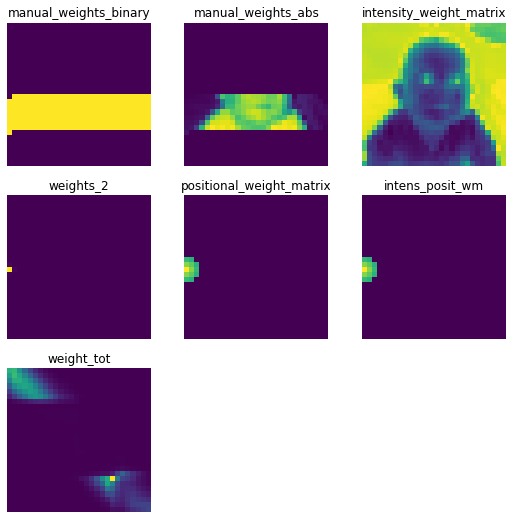

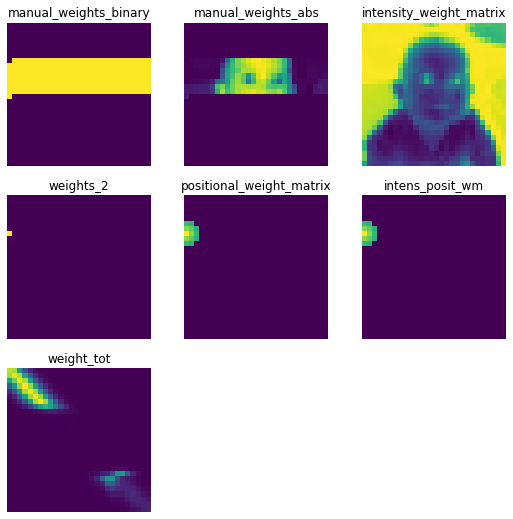

In [24]:
# plot a weight row as an image... should highlight the similar pixels
print(weights[0].shape)

row = 28*28 // 2
images = []
for weight in weights:
    images.append(weight[row].reshape(size))
    
plot_images(images, labels) 

row = 28*28 // 4
images = []
for weight in weights:
    images.append(weight[row].reshape(size))
    
plot_images(images, labels) 

In [5]:
# different valid image sets
# (real images too?)

# different weighting functions
# intens, position, affinity, intens * position...

# plot specific rows of the weights matrix (e.g. for intensity should show similar things in image)

# different weightings with W/np.max(W) (e.g. do we normalize the weights before doing laplace?)

# different laplace solvers
# cheap, expensive, symmetric/none...
# how to handle 0's in D? or... how to handle 0's in d?

# different eigensolvers
# initially try for just one eig solver?
# Time the eigensolvers

# linalg.eig(L)
# np.eig(L)

# linalg.eigh(L)
# linalg.eig(L)
# linalg.eigh(L,D)
# linalg.eig(L,D)
# plus the gvd variants etc....

# lobpcg (specifically setup for finding small eigenvalues unlike most other methods :) )

# outputs
# and with... * 28, * eigval, * np.sqrt(D)
# sign of outputs to make it an indicator vector
# objective, eqconst

# plot the eigenvalues for a different method... (see if > 0)
# plot the eigenvectors for different inputs
# plot ncut cost, at different partitions of the eigenvector range
# ^ and do this for the first so many eigenvectors :)

# also other plots probably mentioned in eigs-test2 or nc-test2/nc-test3... etc